In [1]:
%matplotlib inline
import numpy as onp
import jax.numpy as np
from jax import random
from jax.ops import index, index_update
from jax.config import config

from tqdm.notebook import tqdm
from time import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('talk', 'white')
plt.rcParams["figure.figsize"] = (8,8)

config.update("jax_enable_x64", True)

In [2]:
# Functions
isqrt = lambda x: 1. / np.sqrt(x)
funs = {'sqrt': np.sqrt,
        'isqrt': isqrt,
        'log': np.log,
        'exp': np.exp}

def norm_frob_squared(X):
    return np.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = np.linalg.eigh(X)
    return np.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = np.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return np.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return np.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)

def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.exp(np.sum(np.log(u), axis=0) / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(X)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

def optimal_reference(X):
    u, vs = np.linalg.eigh(X)
    eigval = np.exp(np.sum(np.log(u), axis=0) / X.shape[0])
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    eigvec = np.einsum('...ij,...jk', U, V)
    return np.einsum('...ij,...j,...kj', eigvec, eigval, eigvec)

def corr_from_cov(cov):
    diag = np.sqrt(np.diag(cov))
    return np.einsum('...i,...ij,...j->...ij', 1./diag, cov, 1./diag)


In [38]:
# Random generator
rng = random.PRNGKey(42)

# Noise or nah
eig_noise = False
diag_bari = True
sample_noise = True

# Eigenvalues function ['linear', 'exp', 'constant']
eig_disp = 'exp'

# Eigenvalues hyperparameters
min_eig = 1e-2
cond_number = 1e4

# Wishart DoF
df = int(1e3)

# Number of repetitions
rep = 40

# Sample sizes
sample_size = [10, 100, 1000]

# Matrix dimensions
ps = [5, 10, 20]

# Empty dataframe
dists = pd.DataFrame(columns=['p', 'M', 'r', 'dist'])

for p in ps:
    # Eigenvalues
    max_eig = min_eig * cond_number
    if eig_disp == 'linear':
        eig_vals = np.linspace(min_eig, max_eig, p)
    elif eig_disp == 'exp':
        eig_vals = np.logspace(np.log10(min_eig), np.log10(max_eig), p)
    else:
        eig_vals = np.array([1.] * p)

    if eig_noise:
        rng, *key = random.split(rng, p+1)
        eig_noises = np.array([0 if ((i==0) or (i==p-1)) 
                               else random.normal(key[i]) * eig_vals[i] / 10
                               for i in range(p)])
        eig_vals = np.sort(eig_vals + eig_noises)

    # Eigenvector
    if diag_bari:
        eig_vect = np.identity(p)
    else:
        rng, key = random.split(rng)
        eig_vect = np.linalg.qr(random.normal(key, shape=(p, p)))[0]

    # True barycenter
    true_bari = np.einsum('...ij,...j,...kj', eig_vect, eig_vals, eig_vect)

    for i, M in enumerate(sample_size):
        dist = 0
        tic = time()
        for r in range(rep):
            # Generate M rotations (uniform)
            rng, key = random.split(rng)
            orth = np.linalg.qr(random.normal(key, shape=(M, p, p)))[0]

            if sample_noise:
                rng, key = random.split(rng)
                mvgaus = random.multivariate_normal(key, shape=(M, df),
                                                    mean=np.zeros(shape=(p,)),
                                                    cov=true_bari / df)
                bari = np.einsum('...ji,...jk', mvgaus, mvgaus)
            else:
                bari = true_bari

            # Generate M samples from barycenter
            sample = rotate(bari, orth)
            
            # Find baricenter estimate
            new_eigs = optimal_reference_eigval(sample)
            
            # Compute distance
            d = dist_riem_squared(np.diag(new_eigs), np.diag(eig_vals))
            dist += d
            dists = dists.append({'p':p, 'M':M, 'r':r, 'dist':d}, ignore_index=True)
        toc = time()
        print('{}\t{}\t:\t{:.4f}\t{:.2f} s'.format(p, M, dist / rep, (toc - tic) / rep))

dists['M'] = dists['M'].astype('category')
dists['p'] = dists['p'].astype('category')
dists['r'] = dists['r'].astype('category')
dists['dist'] = dists['dist'].astype(float)
dists.columns = ['Matrix dimension', 'Sample size', 'Repetition', 'Riemannian distance']

5	10	:	0.0011	0.01 s
5	100	:	0.0002	0.02 s
5	1000	:	0.0001	0.16 s
10	10	:	0.0025	0.01 s
10	100	:	0.0006	0.04 s
10	1000	:	0.0004	0.29 s
20	10	:	0.0073	0.02 s
20	100	:	0.0036	0.08 s
20	1000	:	0.0032	0.67 s


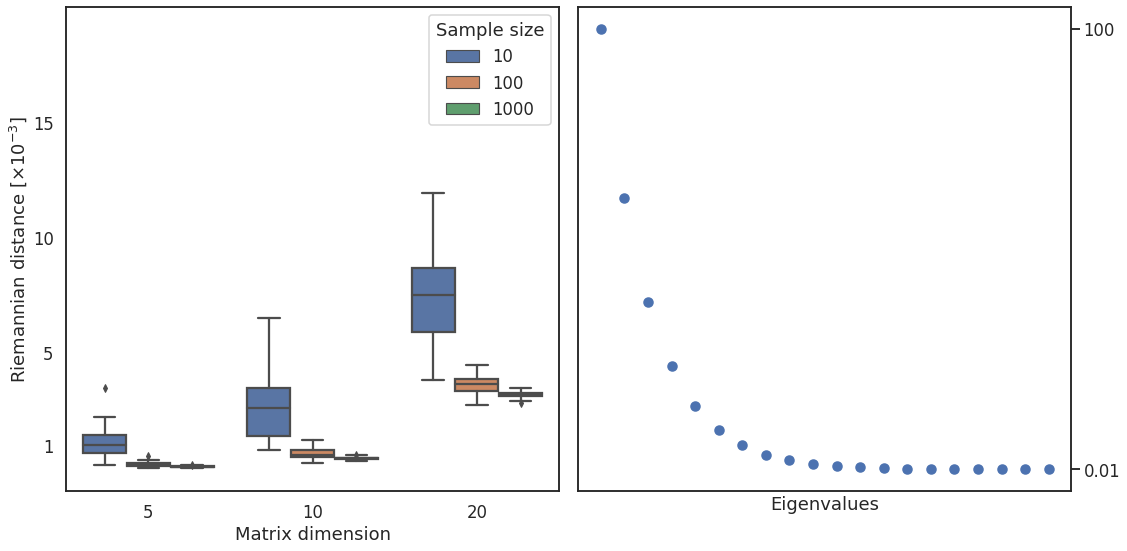

In [39]:
f, a = plt.subplots(1, 2, figsize=(16, 8))
sns.boxplot(data=dists, x='Matrix dimension', y='Riemannian distance', hue='Sample size', ax=a[0])
a[0].set_ylim(bottom=-0.001, top=0.02)
a[0].set_yticks([0.001, 0.005, 0.01, 0.015])
a[0].set_yticklabels(['1', '5', '10', '15'])
a[0].set_ylabel(r'Riemannian distance [$\times10^{-3}$]')

a[1].scatter(range(len(eig_vals)), eig_vals[::-1])
a[1].set_xticks([])
a[1].yaxis.set_label_position("right")
a[1].yaxis.tick_right()
a[1].set_yticks([min_eig, max_eig])
a[1].set_yticklabels([round(min_eig, 2), round(max_eig)])
a[1].set_xlabel('Eigenvalues')

plt.tight_layout()
plt.savefig('../plots/{}.pdf'.format(eig_disp))
plt.show()

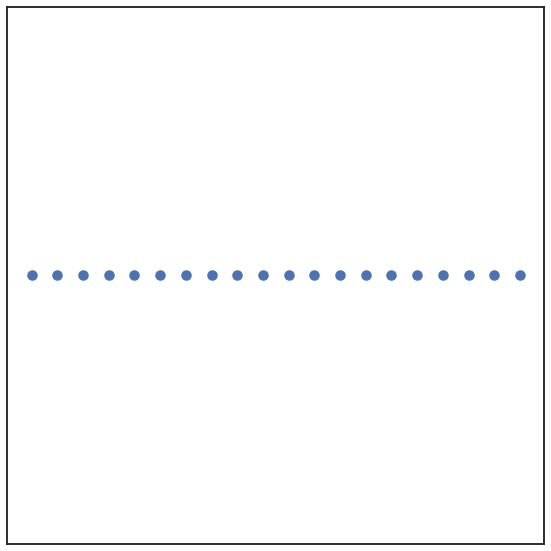

In [5]:
plt.scatter(range(len(eig_vals)), eig_vals[::-1])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('../plots/{}_eig.pdf'.format(eig_disp))
plt.show()